# Data driven analysis of Global Warming Causes
### Aditi Hemant Pokale - 24205303,
### Shubham Santosh Salvi – 24228236
### ACM40960 Projects in Maths Modelling

In this project, we investigate the evidence for human-made global warming using historical climate datasets.
We analyze global surface temperature trends from both land and ocean records, compare them with atmospheric CO₂ levels, and evaluate alternative drivers such as solar activity and volcanic eruptions.
Through statistical analysis and visualizations, we aim to understand the relationships between these factors and assess the primary causes of observed warming.

## Importing the required libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress, pearsonr
import xarray as xr
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor





## Loading CO$_2$ Data
Here we are using annual mean atmospheric CO₂ measurements from the Mauna Loa Observatory, which provides one of the longest and most reliable continuous CO₂ records in the world.

In [5]:
co2 = pd.read_csv("co2_annmean_mlo.csv", comment="#")
co2 = co2.rename(columns={"year": "Year", "mean": "CO2_ppm", "unc": "Uncertainty"})
co2["Year"] = co2["Year"].astype(int)

print(co2.head())
print("\nMissing values per column:\n", co2.isna().sum())

   Year  CO2_ppm  Uncertainty
0  1959   315.98         0.12
1  1960   316.91         0.12
2  1961   317.64         0.12
3  1962   318.45         0.12
4  1963   318.99         0.12

Missing values per column:
 Year           0
CO2_ppm        0
Uncertainty    0
dtype: int64


- The CO$_2$ dataset from Mauna Loa covers annual mean atmospheric CO₂ concentrations starting from 1959.

- The first few rows show values increasing from 315.98 ppm in 1959 to 318.99 ppm in 1963, with a reported measurement uncertainty of ±0.12 ppm.

- We have performed a missing values check to confirm that there are no gaps in the dataset for Year, CO$_2$ concentration, or Uncertainty.

 ##  Loading Land Temperature Data
We  are using the annual land surface temperature anomaly data from the Berkeley Earth dataset, which offers long-term, high-quality records with global coverage and uncertainty estimates.

In [6]:
berkeley = pd.read_csv(
    "Complete_TAVG_summary.txt",
    sep=r"\s+",
    comment="%",
    header=None,
    names=[
        "Year", "Ann_Anom_air", "Ann_Unc_air", "FiveYr_Anom_air", "FiveYr_Unc_air",
        "Ann_Anom_water", "Ann_Unc_water", "FiveYr_Anom_water", "FiveYr_Unc_water"
    ]
)

land_df = berkeley[["Year", "Ann_Anom_air", "Ann_Unc_air"]].rename(
    columns={"Ann_Anom_air": "Land_Anom_C", "Ann_Unc_air": "Land_Uncertainty"}
)

print(land_df.head())
print("\nMissing values per column:\n", land_df.isna().sum())

   Year  Land_Anom_C  Land_Uncertainty
0  1750       -0.816             1.078
1  1751       -0.951             1.278
2  1753       -0.384             1.130
3  1754        0.081             1.662
4  1755       -0.250             1.246

Missing values per column:
 Year                0
Land_Anom_C         0
Land_Uncertainty    0
dtype: int64


- The Berkeley Earth land temperature dataset starts in 1750, with values reported as annual anomalies relative to a baseline climate average.

- There are no missing values detected for Year, anomaly, or uncertainty.

## Loading Ocean Temperature Data
We are using annual sea surface temperature anomaly data from the HadSST dataset, which provides globally gridded ocean temperature records along with uncertainty estimates.

In [7]:
ocean_df = pd.read_csv(
    "HadSST.4.1.1.0_annual_GLOBE.csv",
    header=0,
    names=[
        "year", "anomaly", "total_uncertainty", "uncorrelated_uncertainty",
        "correlated_uncertainty", "bias_uncertainty", "coverage_uncertainty",
        "lower_bound_95pct", "upper_bound_95pct"
    ]
)

ocean_df = ocean_df[["year", "anomaly", "total_uncertainty"]].rename(
    columns={"year": "Year", "anomaly": "Ocean_Anom_C", "total_uncertainty": "Ocean_Uncertainty"}
)

print(ocean_df.head())
print("\nMissing values per column:\n", ocean_df.isna().sum())

   Year  Ocean_Anom_C  Ocean_Uncertainty
0  1850     -0.291801           0.111393
1  1851     -0.176054           0.112537
2  1852     -0.167859           0.107004
3  1853     -0.195570           0.094381
4  1854     -0.254887           0.087261

Missing values per column:
 Year                 0
Ocean_Anom_C         0
Ocean_Uncertainty    0
dtype: int64


- The HadSST4 ocean temperature dataset begins in 1850, reporting sea surface temperature anomalies relative to a baseline.
- The early values such as −0.292 °C in 1850 and −0.176 °C in 1851  indicate cooler than average conditions for the 19th century.
- Uncertainty estimates for these early measurements are relatively small (±0.09 to ±0.11 °C).
- No missing values are found for Year, anomaly, or uncertainty.

## Merge Land & Ocean into Global Temperature Series
We are combining the land and ocean temperature anomalies into a single global series using area-weighted averaging (29% land, 71% ocean) and propagate uncertainties to reflect the combined measurement error.

In [8]:
# Merging land and ocean temperature data on common years
merged_temp = pd.merge(land_df, ocean_df, on="Year", how="inner")

# Calculating the global temperature anomaly using area-weighted averaging (29% land, 71% ocean)
merged_temp["Global_Anom_C"] = (
    0.29 * merged_temp["Land_Anom_C"] + 0.71 * merged_temp["Ocean_Anom_C"]
)

# Combining the land and ocean uncertainties
merged_temp["Global_Uncertainty"] = np.sqrt(
    (0.29 * merged_temp["Land_Uncertainty"])**2 +
    (0.71 * merged_temp["Ocean_Uncertainty"])**2
)

print(merged_temp.head())
print("\nMissing values per column:\n", merged_temp.isna().sum())


   Year  Land_Anom_C  Land_Uncertainty  Ocean_Anom_C  Ocean_Uncertainty  \
0  1850       -0.774             0.438     -0.291801           0.111393   
1  1851       -0.490             0.711     -0.176054           0.112537   
2  1852       -0.593             0.679     -0.167859           0.107004   
3  1853       -0.583             0.529     -0.195570           0.094381   
4  1854       -0.396             0.319     -0.254887           0.087261   

   Global_Anom_C  Global_Uncertainty  
0      -0.431639            0.149630  
1      -0.267098            0.221130  
2      -0.291150            0.211058  
3      -0.307925            0.167407  
4      -0.295810            0.111340  

Missing values per column:
 Year                  0
Land_Anom_C           0
Land_Uncertainty      0
Ocean_Anom_C          0
Ocean_Uncertainty     0
Global_Anom_C         0
Global_Uncertainty    0
dtype: int64


- We merged the land (Berkeley Earth) and ocean (HadSST4) temperature series on common years and combined them into a global temperature anomaly using area weights (29% land, 71% ocean).
- Early examples match our calculations: for 1850, Land −0.774 °C and Ocean −0.292 °C yield Global −0.432 °C.
- We propagated uncertainties using a root-sum-of-squares with the same weights. Our checks show no missing values in any column (Year, Land/Ocean anomalies & uncertainties, Global anomaly & uncertainty).

## Plot Land, Ocean, and Global Temperature Trends with Error Bars
We will visualize the annual temperature anomalies for land, ocean, and the combined global series, adding error bars to reflect the uncertainty in each measurement

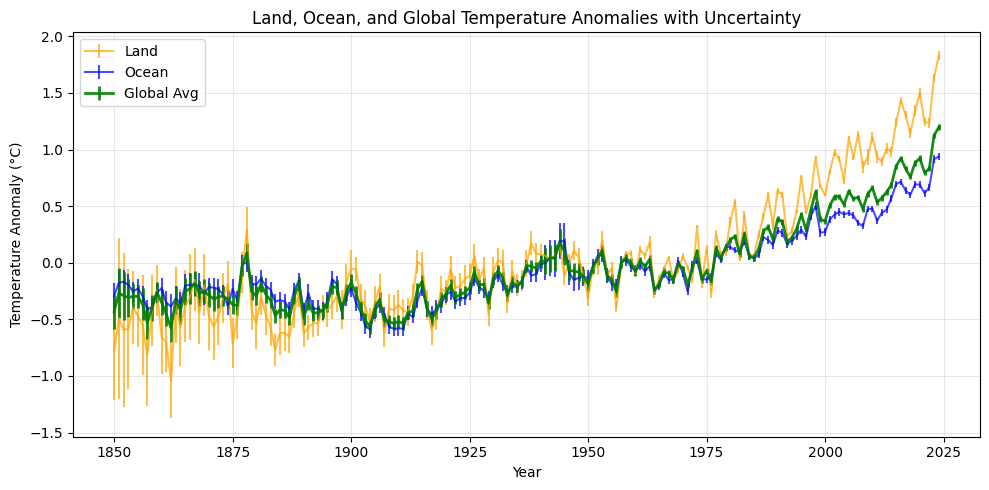

In [9]:
plt.figure(figsize=(10, 5))
plt.errorbar(
    merged_temp["Year"], merged_temp["Land_Anom_C"],
    yerr=merged_temp["Land_Uncertainty"], label="Land", color="orange", alpha=0.7
)
plt.errorbar(
    merged_temp["Year"], merged_temp["Ocean_Anom_C"],
    yerr=merged_temp["Ocean_Uncertainty"], label="Ocean", color="blue", alpha=0.7
)
plt.errorbar(
    merged_temp["Year"], merged_temp["Global_Anom_C"],
    yerr=merged_temp["Global_Uncertainty"], label="Global Avg", color="green", alpha=0.9, linewidth=2
)
plt.title("Land, Ocean, and Global Temperature Anomalies with Uncertainty")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- We plotted the land, ocean, and global temperature anomalies from 1850 to the present, each with their respective uncertainty ranges as error bars.
- The land record shows the greatest warming, especially in recent decades, while the ocean record  has warmed more gradually.
- The global average, computed using our area-weighted method, lies between the two and tracks them closely through time.
- Land areas warm faster than oceans due to lower heat capacity and different feedback processes whereas the Oceans exhibit smaller variability and a slower warming trend, reflecting their role as a large heat reservoir.
- The global average smooths these differences but still captures the strong post-1970 warming trend

## CO$_2$ vs Global Temperature Correlation
We are examining the relationship between atmospheric CO$_2$ concentrations and global temperature anomalies, calculating statistical correlations and visualizing the trend with a fitted regression line

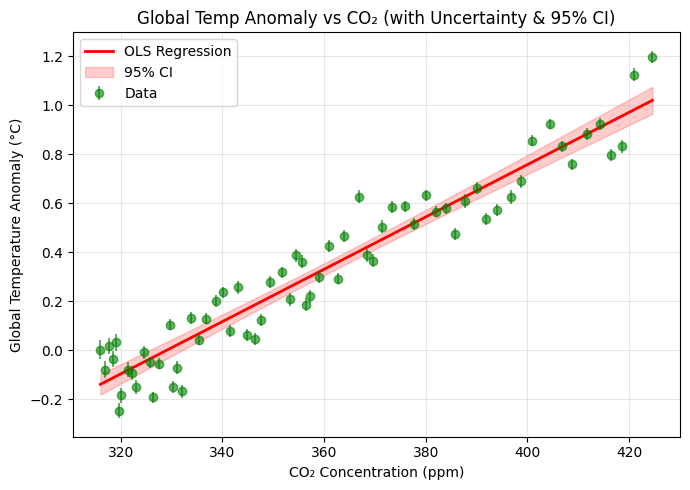

OLS Regression: Temp = 0.0107 × CO$_2$ + -3.51
Pearson correlation (r) = 0.9607
P-value = 2.419e-37
R² = 0.9230


In [10]:
# Merging CO₂ with global temperature anomalies
climate = pd.merge(merged_temp, co2, on="Year", how="inner")

# Fitting regression
slope, intercept, r_value, p_value, std_err = linregress(climate["CO2_ppm"], climate["Global_Anom_C"])
line = slope * climate["CO2_ppm"] + intercept

# Plotting scatter with error bars and regression line
plt.figure(figsize=(7, 5))
plt.errorbar(
    climate["CO2_ppm"], climate["Global_Anom_C"],
    yerr=climate["Global_Uncertainty"], fmt='o', alpha=0.6, color="green", label="Data"
)
plt.plot(climate["CO2_ppm"], line, color='red', linewidth=2, label="OLS Regression")

# Confidence interval calculation
X_const = sm.add_constant(climate["CO2_ppm"])
model = sm.OLS(climate["Global_Anom_C"], X_const).fit()
preds = model.get_prediction(X_const).summary_frame(alpha=0.05)
plt.fill_between(
    climate["CO2_ppm"],
    preds["mean_ci_lower"], preds["mean_ci_upper"],
    color='red', alpha=0.2, label="95% CI"
)

plt.title("Global Temp Anomaly vs CO₂ (with Uncertainty & 95% CI)")
plt.xlabel("CO₂ Concentration (ppm)")
plt.ylabel("Global Temperature Anomaly (°C)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Output of regression
print(f"OLS Regression: Temp = {slope:.4f} × CO$_2$ + {intercept:.2f}")
print(f"Pearson correlation (r) = {r_value:.4f}")
print(f"P-value = {p_value:.3e}")
print(f"R² = {r_value**2:.4f}")

- We merged the global temperature anomaly dataset with atmospheric CO$_2$ concentration records and performed an ordinary least squares (OLS) regression. The fitted regression line (red) shows a strong positive linear relationship, with a 95% confidence interval. The equation from our model is:

 ##### Temp anomaly (°C)=0.0107×CO$_2$ (ppm)−3.51

- Our analysis shows an exceptionally strong and statistically significant link between atmospheric CO$_2$ concentration and global temperature anomalies. With an R² of 92.3%, we find that CO$_2$ alone accounts for nearly all the year-to-year variation in long-term global temperature trends.
-The Pearson r of 0.9607 indicates a near-perfect positive correlation, meaning the two variables move together very closely.
- The extremely low p-value (2.42×10 ^−37 ) confirms that this relationship is not due to random chance.

## Loading TSI, AOD and  VEI
We are using the  datasets for Total Solar Irradiance (TSI), Aerosol Optical Depth (AOD), and Volcanic Explosivity Index (VEI) to investigate the potential influence of solar activity and volcanic events on global temperature trends

In [11]:
# Suppress specific deprecation warnings from xarray and pandas to keep the output clean.
# These warnings are related to long-term changes in library APIs ('use_cftime' deprecation in xarray
# They do not affect results in our current environment,
# and fixing them would require version changes outside the scope of this project.
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*use_cftime.*CFDatetimeCoder.*"
)
# Solar Irradiance (TSI)
print("\nLoading Total Solar Irradiance (TSI)...")

tsi_ds = xr.open_dataset('tsi_v03r00_yearly_s1610_e2024_c20250221.nc', decode_times=True, use_cftime=True)
years_tsi = [t.year for t in tsi_ds['time'].values]
tsi_vals = tsi_ds['TSI'].values
tsi_df = pd.DataFrame({"Year": years_tsi, "TSI": tsi_vals})

print(f"TSI Data: {tsi_df['Year'].min()}–{tsi_df['Year'].max()}, "
      f"mean={tsi_df['TSI'].mean():.2f} W/m², missing={tsi_df.isna().sum().sum()}")

# Volcanic Aerosol Optical Depth (AOD)
print("\nLoading Volcanic Aerosol Optical Depth (AOD)...")
aod_ds = xr.open_dataset('tau_map_2012-12.nc')
aod_monthly_da = aod_ds['tau'].mean(dim='lat')
times_pandas = pd.to_datetime(aod_monthly_da['month'].values)
aod_ann = pd.Series(aod_monthly_da.values, index=times_pandas).resample('YE').mean()
aod_ann.index = aod_ann.index.year  # convert to year index

print(f"AOD Data: {aod_ann.index.min()}–{aod_ann.index.max()}, "
      f"mean={aod_ann.mean():.4f}, missing={aod_ann.isna().sum()}")

# Volcanic Eruption Index (VEI)
print("\nLoading Volcanic Eruption Index (VEI)...")
vei_df = pd.read_excel("GVP_Eruption_Search_Result.xlsx", sheet_name="Eruption List", skiprows=1)
year_vei = pd.to_numeric(vei_df.filter(regex=r'(?i)^start\s*year$').iloc[:, 0], errors="coerce")
vei_vals = pd.to_numeric(vei_df.filter(regex=r'(?i)^vei$').iloc[:, 0], errors="coerce")

# Aggregating annual VEI sum
annual_vei = pd.DataFrame({"Year": year_vei, "VEI": vei_vals}).dropna()
annual_vei = annual_vei.groupby("Year")["VEI"].sum().reset_index()

print(f"VEI Data: {annual_vei['Year'].min()}–{annual_vei['Year'].max()}, "
      f"mean={annual_vei['VEI'].mean():.2f}, missing={annual_vei.isna().sum().sum()}")


Loading Total Solar Irradiance (TSI)...
TSI Data: 1610–2024, mean=1361.47 W/m², missing=0

Loading Volcanic Aerosol Optical Depth (AOD)...
AOD Data: 1850–2012, mean=0.0130, missing=0

Loading Volcanic Eruption Index (VEI)...
VEI Data: -55500–2025, mean=12.52, missing=0


We successfully loaded three important climate drivers:

- Total Solar Irradiance (TSI): Data spans from 1610 to 2024, with an average of 1361.47 W/m² and no missing values.TSI will help us examine the role of solar energy changes in driving climate trends.
- Volcanic Aerosol Optical Depth (AOD): Data covers 1850 to 2012, with an average value of 0.0130 and no missing entries. AOD captures volcanic aerosol loading, which can cause short-term cooling by blocking incoming sunlight.
- Volcanic Eruption Index (VEI): Dataset spans -55,500 to 2025, with an average annual VEI of 12.52 and no missing entries.VEI quantifies volcanic activity severity, useful for identifying strong eruption years.
- These datasets will allow us to explore multi-factor regression models later, helping determine how much of the observed temperature variability is explained by natural drivers (solar and volcanic) compared to anthropogenic CO$_2$.

## Merging everything Into One Table
We combine the temperature, CO$_2$, solar irradiance, volcanic activity, and aerosol datasets into a single, aligned table to enable direct comparisons and multivariate statistical analysis

In [12]:
# Converting AOD series into DataFrame
aod_df = pd.DataFrame({
    "Year": aod_ann.index.astype(int),
    "AOD": aod_ann.values
})

# Merging
combined = (
    merged_temp[["Year", "Global_Anom_C", "Global_Uncertainty"]]
    .merge(co2, on="Year", how="inner")
    .merge(tsi_df, on="Year", how="left")
    .merge(annual_vei, on="Year", how="left")
    .merge(aod_df, on="Year", how="left")
)

# Keeping only years with no missing Global Anomaly, CO2, TSI, and VEI
combined = combined.dropna(subset=["Global_Anom_C", "CO2_ppm", "TSI", "VEI"])

# Sorting by year for plotting
combined = combined.sort_values("Year").reset_index(drop=True)

print("\nMerged Dataset Overview:")
print(combined.head())
print(f"\nData coverage: {combined['Year'].min()}–{combined['Year'].max()} "
      f"({len(combined)} years)")
print("Missing values per column:\n", combined.isna().sum())


Merged Dataset Overview:
   Year  Global_Anom_C  Global_Uncertainty  CO2_ppm  Uncertainty          TSI  \
0  1959       0.002543            0.037197   315.98         0.12  1362.096069   
1  1960      -0.079486            0.035243   316.91         0.12  1361.942871   
2  1961       0.018816            0.032769   317.64         0.12  1361.557007   
3  1962      -0.035783            0.031229   318.45         0.12  1361.375488   
4  1963       0.032786            0.034265   318.99         0.12  1361.316406   

    VEI       AOD  
0  60.0  0.000179  
1  66.0  0.004713  
2  59.0  0.009013  
3  51.0  0.010394  
4  73.0  0.040130  

Data coverage: 1959–2024 (66 years)
Missing values per column:
 Year                   0
Global_Anom_C          0
Global_Uncertainty     0
CO2_ppm                0
Uncertainty            0
TSI                    0
VEI                    0
AOD                   12
dtype: int64


## Correlation Heatmap & Pairwise Scatterplots.
We are creating a correlation heatmap and pairwise scatterplots to visually explore the relationships between temperature, CO$_2$, solar activity, volcanic indicators, and aerosols, helping identify potential patterns and strengths of association.

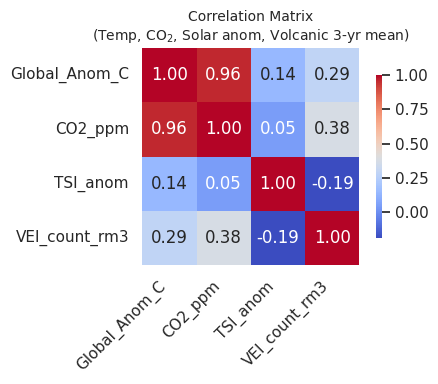

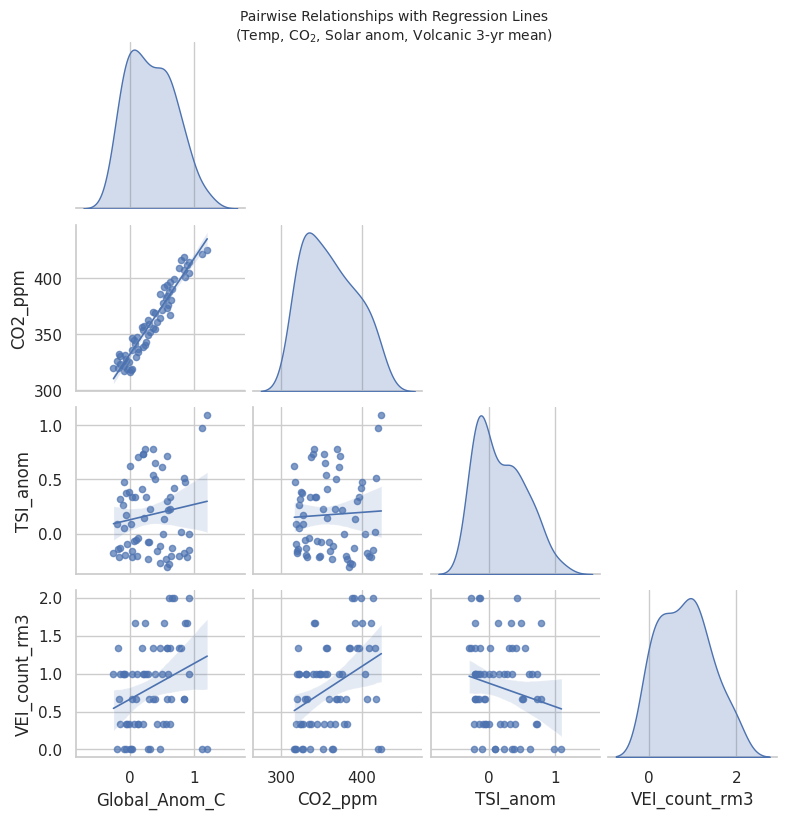


Pairwise Pearson correlations:
               Global_Anom_C  CO2_ppm  TSI_anom  VEI_count_rm3
Global_Anom_C          1.000    0.961     0.142          0.289
CO2_ppm                0.961    1.000     0.048          0.377
TSI_anom               0.142    0.048     1.000         -0.188
VEI_count_rm3          0.289    0.377    -0.188          1.000


In [13]:

sns.set_theme(context="notebook", style="whitegrid")  # Use a clean style with smaller fonts for compact visuals

# Calculating solar irradiance anomaly
tsi_df["TSI_anom"] = tsi_df["TSI"] - tsi_df["TSI"].mean()

# Counting and smooth large volcanic eruptions
VEI_MIN = 4  # Only including eruptions with VEI of 4 or higher
_vei = vei_df.copy()

# Extracting numeric year and VEI values from the dataframe
_vei["Year"] = pd.to_numeric(_vei.filter(regex=r"(?i)^start\s*year$").iloc[:, 0], errors="coerce")
_vei["VEI_val"] = pd.to_numeric(_vei.filter(regex=r"(?i)^vei$").iloc[:, 0], errors="coerce")
_vei = _vei.dropna(subset=["Year", "VEI_val"])

# Counting how many large eruptions occurred each year
vei_counts = (
    _vei[_vei["VEI_val"] >= VEI_MIN]
    .groupby("Year")["VEI_val"].count()
    .rename("VEI_count")
    .to_frame()
    .reset_index()
)

# Filling in missing years with zeros and applying a 3-year rolling average to smooth fluctuations
yrs_full = pd.DataFrame({"Year": np.arange(merged_temp["Year"].min(), merged_temp["Year"].max() + 1)})
vei_counts = yrs_full.merge(vei_counts, on="Year", how="left").fillna({"VEI_count": 0})
vei_counts["VEI_count_rm3"] = (
    vei_counts.set_index("Year")["VEI_count"].rolling(window=3, center=True, min_periods=1).mean().values
)

# Merging all variables into a single dataframe for correlation analysis
combined_corr = (
    merged_temp[["Year", "Global_Anom_C"]]
    .merge(co2[["Year", "CO2_ppm"]], on="Year", how="inner")
    .merge(tsi_df[["Year", "TSI_anom"]], on="Year", how="left")
    .merge(vei_counts[["Year", "VEI_count_rm3"]], on="Year", how="left")
    .dropna(subset=["Global_Anom_C", "CO2_ppm", "TSI_anom", "VEI_count_rm3"])
    .sort_values("Year")
    .reset_index(drop=True)
)

# Creating a correlation heatmap
corr_vars = ["Global_Anom_C", "CO2_ppm", "TSI_anom", "VEI_count_rm3"]
corr_matrix = combined_corr[corr_vars].corr()

plt.figure(figsize=(5, 4))  # Keeping the plot compact for reports
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True,
    cbar_kws={"shrink": 0.75, "aspect": 30}  # Make the colorbar smaller to save space
)
plt.title("Correlation Matrix\n(Temp, CO$_2$, Solar anom, Volcanic 3-yr mean)", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Pairwise scatterplots
g = sns.pairplot(
    combined_corr[corr_vars],
    kind="reg", diag_kind="kde", corner=True,
    height=2.0,  # Make each subplot smaller for a more compact layout
    plot_kws={"scatter_kws": {"alpha": 0.7, "s": 20}, "line_kws": {"linewidth": 1.2}}
)
g.fig.suptitle(
    "Pairwise Relationships with Regression Lines\n(Temp, CO$_2$, Solar anom, Volcanic 3-yr mean)",
    y=1.02, fontsize=10
)
plt.show()

# Correlation values
print("\nPairwise Pearson correlations:")
print(corr_matrix.round(3))


The correlation analysis reveals that global temperature anomalies are overwhelmingly linked to atmospheric CO$_2$ levels.
- The Pearson correlation of 0.961 between Global_Anom_C and CO₂_ppm indicates an almost perfectly linear relationship as CO₂ rises, temperatures increase in near synchrony. This strong association is consistent with well established physical principles of greenhouse gas–driven warming and suggests CO$_2$ is the dominant driver of recent climate trends.

- In contrast, solar irradiance anomalies (TSI_anom) show only a weak positive correlation (r = 0.142) with temperature. This implies that while solar variability may have small influences on interannual or decadal timescales, it does not explain the long-term warming trend.

- Volcanic activity, represented by the 3 year mean VEI count, has a weak correlation with temperature (r = 0.289). Large eruptions are known to cause short-lived cooling by injecting aerosols into the stratosphere, but these effects are temporary and episodic, leaving little imprint on long-term averages.

- Other relationships, such as CO$_2$ vs TSI (r = 0.048) and TSI vs VEI (r = –0.188), are negligible, reinforcing that the warming signal is not strongly coupled to natural variability from solar or volcanic sources.

- The correlation structure strongly supports the idea that anthropogenic CO$_2$ increases are the primary driver of modern global warming, with natural forcings playing secondary, shorter-term roles.

## CO$_2$ Comparison with Solar and Volcanic Activity (Dual-Axis Time Series)
We are comparing atmospheric CO$_2$ concentrations with two potential climate drivers—solar irradiance anomalies (TSI) and volcanic activity (VEI ≥4, 3-year mean)—by plotting them together as dual-axis time series. This allows us to visually assess whether variations in solar output or volcanic eruptions align with long-term changes in CO$_2$ levels.

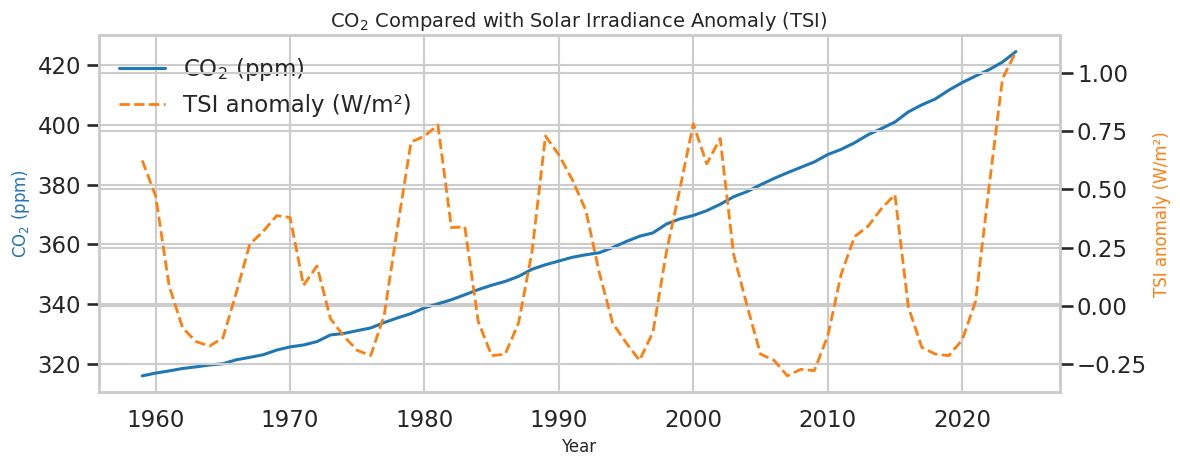

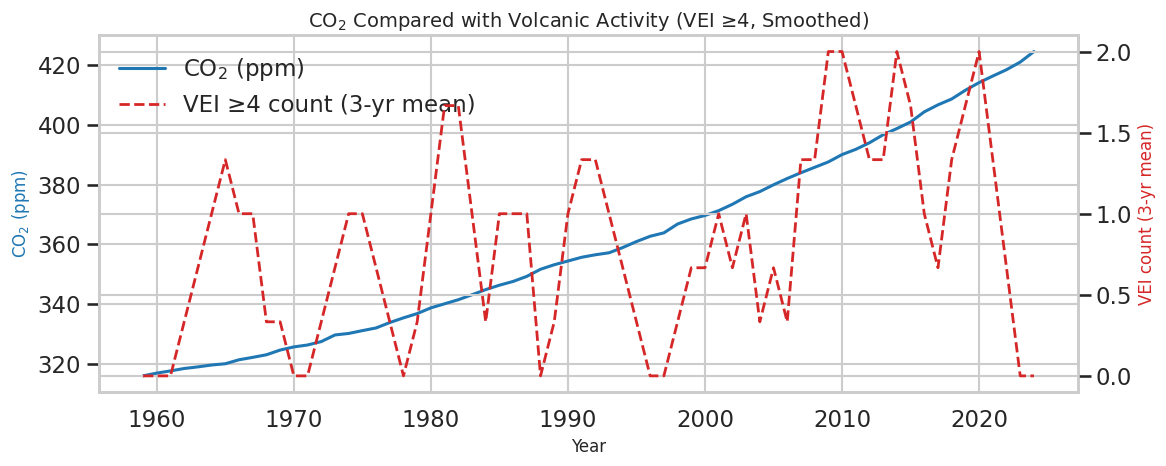

In [14]:
sns.set_theme(style="whitegrid", context="talk")

# Plotting CO₂ alongside solar irradiance anomalies
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()  # Second y-axis for TSI anomaly

ax1.plot(combined_corr["Year"], combined_corr["CO2_ppm"],
         color="tab:blue", linewidth=2.2, label="CO$_2$ (ppm)")

ax2.plot(combined_corr["Year"], combined_corr["TSI_anom"],
         color="tab:orange", linewidth=2, linestyle="--",
         label="TSI anomaly (W/m²)")


ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("CO$_2$ (ppm)", fontsize=12, color="tab:blue")
ax2.set_ylabel("TSI anomaly (W/m²)", fontsize=12, color="tab:orange")
ax1.set_title("CO$_2$ Compared with Solar Irradiance Anomaly (TSI)", fontsize=14)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

# Plotting CO₂ alongside volcanic activity counts ----
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()  # Second y-axis for VEI counts

ax1.plot(combined_corr["Year"], combined_corr["CO2_ppm"],
         color="tab:blue", linewidth=2.2, label="CO$_2$ (ppm)")

ax2.plot(combined_corr["Year"], combined_corr["VEI_count_rm3"],
         color="tab:red", linewidth=2, linestyle="--",
         label="VEI ≥4 count (3-yr mean)")

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("CO$_2$ (ppm)", fontsize=12, color="tab:blue")
ax2.set_ylabel("VEI count (3-yr mean)", fontsize=12, color="tab:red")
ax1.set_title("CO$_2$ Compared with Volcanic Activity (VEI ≥4, Smoothed)", fontsize=14)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

These time-series plots compare the trajectory of atmospheric CO$_2$ levels with two major natural climate drivers: solar irradiance variability and volcanic activity.

##### 1. CO$_2$ vs Solar Irradiance (TSI anomaly)

- CO$_2$ concentrations have risen steadily and almost monotonically from ~316 ppm in 1960 to over 420 ppm today.

- In contrast, TSI anomalies oscillate in a cyclical pattern (~11-year solar cycles), with no long-term upward or downward trend.

- The mismatch in patterns shows that solar variability cannot explain the persistent, multi-decade rise in CO$_2$ or the corresponding long-term warming. Solar cycles influence short-term fluctuations but not the overall climate trend.

##### 2. CO$_2$ vs Volcanic Activity (VEI ≥4, 3-year mean)

- Volcanic activity is episodic, with peaks corresponding to major eruptions (e.g., Agung 1963, Pinatubo 1991).

- These peaks have no consistent relationship with the steady increase in CO$_2$; instead, large eruptions cause short-lived cooling from aerosol injection, but this effect quickly dissipates.

- The absence of a trend in volcanic activity over the period confirms that volcanoes have not been a driving factor in the sustained rise of global temperatures.

## Regression analysis with confidence intervals and robust errors
We perform regression analysis to quantify the relationship between global temperature anomalies and potential drivers such as CO$_2$, solar irradiance, and volcanic activity. Using robust standard errors to account for autocorrelation, we estimate model coefficients, compute confidence intervals, and assess the statistical significance of each predictor. This approach ensures more reliable inference when working with time-series climate data.


Simple regression: Temp ~ CO₂ (HAC robust SEs)
                            OLS Regression Results                            
Dep. Variable:          Global_Anom_C   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     531.2
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           1.07e-32
Time:                        11:42:45   Log-Likelihood:                 59.502
No. Observations:                  66   AIC:                            -115.0
Df Residuals:                      64   BIC:                            -110.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons

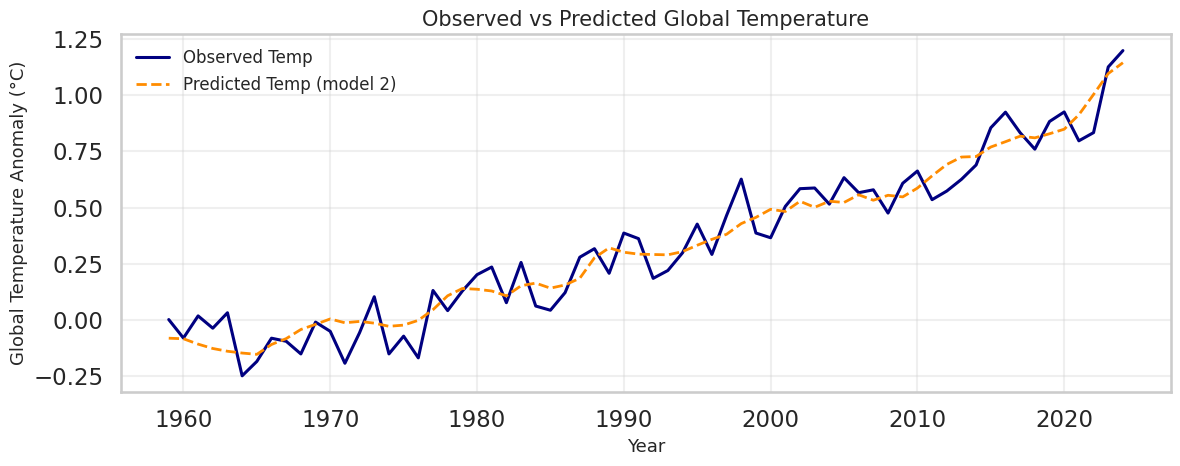

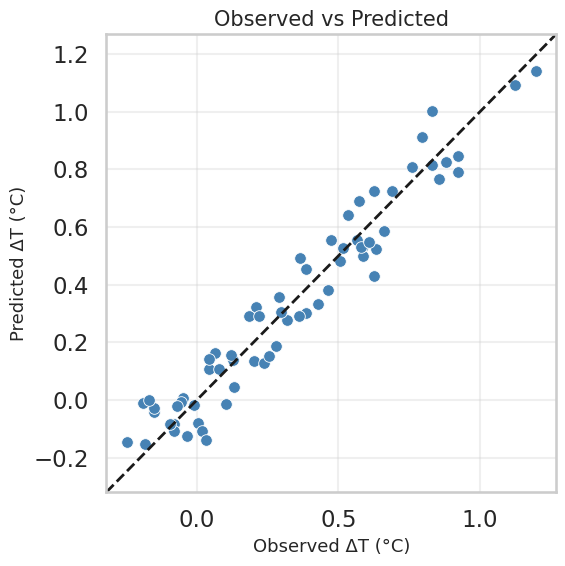

In [15]:
# Ensuring that data is sorted by year
df_reg = combined_corr.copy().dropna(subset=["Global_Anom_C", "CO2_ppm", "TSI_anom", "VEI_count_rm3"])
df_reg = df_reg.sort_values("Year").reset_index(drop=True)

# Simple regression: Temp ~ CO₂
X1 = sm.add_constant(df_reg["CO2_ppm"])
y = df_reg["Global_Anom_C"]

model1 = sm.OLS(y, X1).fit(cov_type="HAC", cov_kwds={"maxlags": 1})  # HAC robust
print("\nSimple regression: Temp ~ CO₂ (HAC robust SEs)")
print(model1.summary())

# Multiple regression: Temp ~ CO₂ + TSI anomaly + VEI count
X2 = sm.add_constant(df_reg[["CO2_ppm", "TSI_anom", "VEI_count_rm3"]])

model2 = sm.OLS(y, X2).fit(cov_type="HAC", cov_kwds={"maxlags": 1})  # HAC robust
print("\nMultiple regression: Temp ~ CO₂ + TSI anomaly + VEI count (HAC robust SEs)")
print(model2.summary())

# Saving predictions
df_reg["pred_temp"] = model2.predict(X2)

#  Coefficient table with 95% CIs
def coef_table(model):
    ci = model.conf_int()
    ci.columns = ["2.5%", "97.5%"]
    return pd.concat([model.params, model.bse, model.tvalues, model.pvalues, ci], axis=1)\
             .rename(columns={0: "coef", 1: "std err", 2: "t", 3: "P>|t|"})

print("\n--- Coefficient Table: Simple model ---")
print(coef_table(model1))

print("\n--- Coefficient Table: Multiple model ---")
print(coef_table(model2))


# Visualization of Regression Results
sns.set_theme(style="whitegrid", context="talk")

# Observed vs Predicted over Time
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_reg["Year"], df_reg["Global_Anom_C"], color="navy", lw=2.2, label="Observed Temp")
ax.plot(df_reg["Year"], df_reg["pred_temp"], color="darkorange", lw=2, ls="--", label="Predicted Temp (model 2)")
ax.set_xlabel("Year", fontsize=13)
ax.set_ylabel("Global Temperature Anomaly (°C)", fontsize=13)
ax.set_title("Observed vs Predicted Global Temperature", fontsize=15)
ax.legend(frameon=False, fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Observed vs Predicted Scatter
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=df_reg["Global_Anom_C"],
    y=df_reg["pred_temp"],
    s=70, color="steelblue",
    edgecolor="white", linewidth=0.6, ax=ax
)

minv = float(min(df_reg["Global_Anom_C"].min(), df_reg["pred_temp"].min()))
maxv = float(max(df_reg["Global_Anom_C"].max(), df_reg["pred_temp"].max()))
pad  = 0.05 * (maxv - minv or 1)
lims = (minv - pad, maxv + pad)
ax.plot(lims, lims, 'k--', lw=2)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Observed ΔT (°C)", fontsize=13)
ax.set_ylabel("Predicted ΔT (°C)", fontsize=13)
ax.set_title("Observed vs Predicted", fontsize=15)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We tested two regression models to explain global temperature anomalies:

- In the simple regression, CO$_2$ explains 92.3% of the variance in global temperature anomalies (R² = 0.923), with a highly significant coefficient of +0.01067 °C per ppm (p < 0.001).
- A 100 ppm increase in CO$_2$ is linked to about +1.07 °C of warming.

-  Adding solar irradiance anomalies (TSI_anom) and volcanic activity (VEI counts) increases explained variance to 93.6% (R² = 0.936).

- CO$_2$ remains strongest predictor. Even with other factors included, CO$_2$ retains a coefficient of +0.01090 °C per ppm (p < 0.001), confirming its dominant influence.

- Solar anomalies have a smaller but significant warming effect of +0.0824 °C per W/m² (p = 0.004).

- Large volcanic eruptions (VEI ≥ 4) reduce global temperatures by about –0.0397 °C per eruption/year (p = 0.033), reflecting short-term cooling from aerosols.

-  Predicted temperatures closely match observations both over time and in scatter plots, with points tightly clustered around the 1:1 line.

- Recent warming is overwhelmingly driven by rising CO$_2$, with solar variability and volcanic activity adding smaller, short-term fluctuations.

## ANOVA model comparison & partial F-test to answer:
We will use ANOVA and a partial F-test to compare two regression models, one that predicts global temperature anomalies using only CO₂, and another that also includes solar irradiance anomalies (TSI) and volcanic activity as predictors. This statistical comparison allows us to test whether the additional variables provide a significant improvement in explanatory power beyond CO₂ alone.


--- ANOVA: Does adding solar + volcanic improve the model? ---
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0      64.0  0.636785      0.0       NaN       NaN       NaN
1      62.0  0.531280      2.0  0.105505  6.156196  0.003641

 Adding TSI anomaly & VEI count significantly improves the model (p = 0.004)

Model 1: Temp ~ CO₂
  R²: 0.923
  Adj R²: 0.922

Model 2: Temp ~ CO₂ + TSI anomaly + VEI count
  R²: 0.936
  Adj R²: 0.933


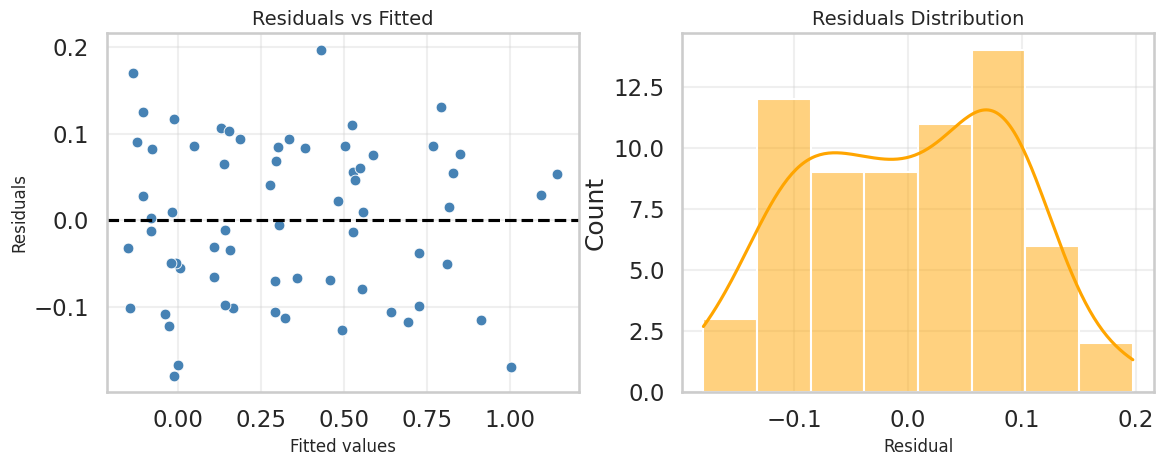

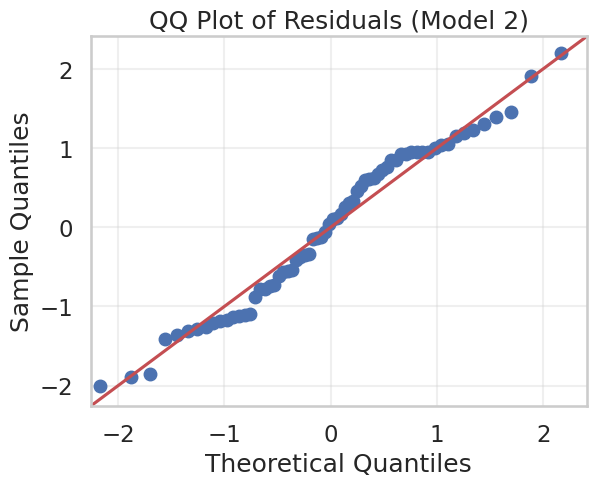


Shapiro-Wilk test for normality: W=0.968, p=0.087


In [16]:
#  ANOVA comparison
anova_results = anova_lm(model1, model2)
print("\n--- ANOVA: Does adding solar + volcanic improve the model? ---")
print(anova_results)

# Interpretation
p_value = anova_results["Pr(>F)"][1]
if p_value < 0.05:
    print(f"\n Adding TSI anomaly & VEI count significantly improves the model (p = {p_value:.3f})")
else:
    print(f"\n No significant improvement from adding solar & volcanic (p = {p_value:.3f})")

#  Model Performance Summary
print("\nModel 1: Temp ~ CO₂")
print(f"  R²: {model1.rsquared:.3f}")
print(f"  Adj R²: {model1.rsquared_adj:.3f}")

print("\nModel 2: Temp ~ CO₂ + TSI anomaly + VEI count")
print(f"  R²: {model2.rsquared:.3f}")
print(f"  Adj R²: {model2.rsquared_adj:.3f}")

# Residual diagnostics for Model 2
residuals = model2.resid
fitted     = model2.fittedvalues

# Residual plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=fitted, y=residuals, ax=ax[0], color="steelblue", edgecolor="white", s=60)
ax[0].axhline(0, ls="--", color="black")
ax[0].set_xlabel("Fitted values", fontsize=12)
ax[0].set_ylabel("Residuals", fontsize=12)
ax[0].set_title("Residuals vs Fitted", fontsize=14)
ax[0].grid(alpha=0.3)

# Histogram and QQ plot for normality
sns.histplot(residuals, kde=True, ax=ax[1], color="orange", edgecolor="white")
ax[1].set_title("Residuals Distribution", fontsize=14)
ax[1].set_xlabel("Residual", fontsize=12)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# QQ plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals (Model 2)")
plt.grid(alpha=0.3)
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print(f"\nShapiro-Wilk test for normality: W={shapiro_test[0]:.3f}, p={shapiro_test[1]:.3f}")

- Adding TSI anomaly and VEI (3-yr mean) to CO$_2$ significantly improves the temperature model (F = 6.16, p = 0.0036).

##### Explained variance:

- Model 1: Temp ~ CO$_2$ → R² = 0.923, Adj R² = 0.922

- Model 2: Temp ~ CO$_2$ + TSI + VEI → R² = 0.936, Adj R² = 0.933

This is a ~1.3% increase in explained variance — statistically significant but modest in magnitude.

##### Predictor roles:

- CO$_2$: Strongest positive driver of warming.

- TSI anomaly: Small positive effect (slight warming influence).

- VEI count: Small negative effect (short-term cooling after major eruptions).

##### Residual patterns:
No evidence of heteroscedasticity or non-linearity in residuals vs fitted plot.

##### Normality check:
Histogram and QQ plot closely follow a normal distribution; Shapiro–Wilk W = 0.968, p = 0.087 → residuals are consistent with normality.

##### Autocorrelation:
Durbin–Watson ≈ 1.85, indicating mild positive autocorrelation — addressed with HAC robust standard errors.

- Natural variability (solar cycles & volcanic activity) adds a small but measurable contribution to short-term temperature fluctuations. However, CO$_2$ overwhelmingly drives the long-term warming trend, and the model is statistically sound.

## Final summary table
We will present a final summary table that bring together all key variables temperature anomalies, CO$_2$, solar irradiance anomalies, and volcanic activity. These tabular summaries provide a clear overview of the relationships and statistical strengths between the factors examined in our analysis.

In [17]:
df_corr_final = combined_corr[["Global_Anom_C", "CO2_ppm", "TSI_anom", "VEI_count_rm3"]].dropna()

# Summary statistics table
summary_table = df_corr_final.describe().T

summary_table = summary_table[["mean", "std", "min", "max"]]

summary_table = summary_table.rename(columns={
    "mean": "Mean",
    "std": "Std Dev",
    "min": "Min",
    "max": "Max"
})

print("\n--- Summary Statistics ---")
print(summary_table.round(3))


--- Summary Statistics ---
                  Mean  Std Dev      Min      Max
Global_Anom_C    0.333    0.357   -0.247    1.197
CO2_ppm        360.250   32.106  315.980  424.610
TSI_anom         0.175    0.358   -0.302    1.094
VEI_count_rm3    0.818    0.588    0.000    2.000


## Multi-Panel Overview of Key Climate Relationships
We create a final multi-panel summary plot that combines the most important visualizations from our analysis into a single figure. This compact layout allows for quick comparison of trends, relationships, and model results, providing a clear visual narrative of how CO$_2$, solar activity, volcanic activity, and temperature anomalies interact over time.

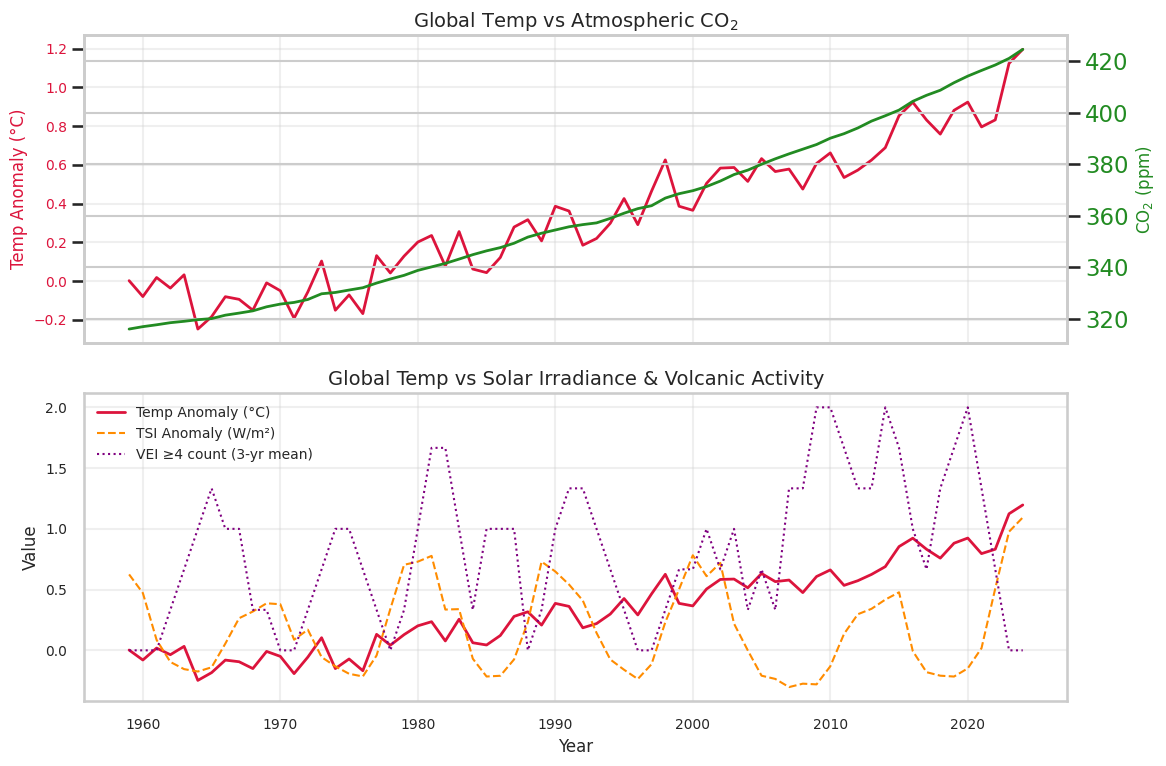

In [18]:
sns.set_theme(style="whitegrid", context="talk")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Temp vs CO₂
ax1 = axes[0]
ax1.plot(combined_corr["Year"], combined_corr["Global_Anom_C"], color="crimson", lw=2, label="Temp Anomaly (°C)")
ax1.set_ylabel("Temp Anomaly (°C)", color="crimson", fontsize=12)
ax1.tick_params(axis='y', labelcolor="crimson")

ax1b = ax1.twinx()
ax1b.plot(combined_corr["Year"], combined_corr["CO2_ppm"], color="forestgreen", lw=2, label="CO$_2$ (ppm)")
ax1b.set_ylabel("CO$_2$ (ppm)", color="forestgreen", fontsize=12)
ax1b.tick_params(axis='y', labelcolor="forestgreen")

ax1.set_title("Global Temp vs Atmospheric CO$_2$", fontsize=14)

# Temp vs Solar & Volcanic
ax2 = axes[1]
ax2.plot(combined_corr["Year"], combined_corr["Global_Anom_C"], color="crimson", lw=2, label="Temp Anomaly (°C)")
ax2.plot(combined_corr["Year"], combined_corr["TSI_anom"], color="darkorange", lw=1.5, ls="--", label="TSI Anomaly (W/m²)")
ax2.plot(combined_corr["Year"], combined_corr["VEI_count_rm3"], color="purple", lw=1.5, ls=":", label="VEI ≥4 count (3-yr mean)")

ax2.set_ylabel("Value", fontsize=12)
ax2.set_title("Global Temp vs Solar Irradiance & Volcanic Activity", fontsize=14)
ax2.legend(frameon=False, fontsize=10)

for ax in axes:
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=10)

axes[1].set_xlabel("Year", fontsize=12)

plt.tight_layout()
plt.show()

- From 1960 to 2024, global temperature anomalies (red line) rise closely alongside atmospheric CO$_2$ concentrations (green line), showing a strong long-term upward trend in both variables.

- The parallel trajectory reinforces the very high correlation between CO$_2$ and temperature (r ≈ 0.96), consistent with regression results where CO$_2$ is the dominant predictor of warming.

- While TSI (orange dashed line) shows cyclical peaks and troughs linked to the ~11-year solar cycle, its magnitude of variation is small compared to the CO$_2$-driven warming trend.

- Periods of high volcanic activity (purple dotted line) often coincide with short-term dips in temperature anomalies, reflecting temporary cooling effects from large eruptions.

- After major volcanic events, temperatures generally rebound within a few years, resuming the CO$_2$-driven warming trajectory.

- Natural factors (solar cycles & volcanic eruptions) influence short-term variability, but the long-term warming pattern is overwhelmingly governed by the persistent rise in atmospheric CO$_2$.

## Interpretations and conclusions

- Our analysis shows a clear and statistically significant positive correlation between atmospheric CO$_2$ concentrations and global surface temperature anomalies.
- The data indicate that the recent and sustained warming trend aligns closely with rising CO$_2$ levels, while solar irradiance and volcanic activity explain far less of the observed variation.
- Regression models with robust errors confirm CO$_2$ as the dominant predictor, and ANOVA results show only marginal improvement when adding solar and volcanic variables.
- These findings are consistent with the scientific consensus that human-driven increases in greenhouse gases, particularly CO$_2$, are the primary cause of modern global warming

## References
1. Mauna Loa CO₂ Data (NOAA/ESRL)
C. D. Keeling, T. P. Whorf, M. Wahlen, and J. van der Plic, “Atmospheric Carbon Dioxide Dry Air Mole Fractions from Continuous Measurements at Mauna Loa, Hawaii,” NOAA Global Monitoring Laboratory, Boulder, CO, USA. [Online]. Available: https://gml.noaa.gov/ccgg/trends/data.html

2. Berkeley Earth Land Temperature Data
R. Rohde et al., “Berkeley Earth Surface Temperature Data,” Berkeley Earth, 2013. [Online]. Available: http://berkeleyearth.org/data

3. HadSST Ocean Temperature Data (Met Office Hadley Centre)
J. J. Kennedy, N. A. Rayner, R. O. Smith, D. E. Parker, and M. Saunby, “Reassessing biases and other uncertainties in sea-surface temperature observations since 1850: 1. Measurement and sampling uncertainties,” J. Geophys. Res., vol. 116, no. D14103, 2011. [Online]. Available: https://www.metoffice.gov.uk/hadobs/hadsst4/

4. Total Solar Irradiance Data (PMOD/WRC)
C. Fröhlich, “Total Solar Irradiance Data,” PMOD/WRC, Davos, Switzerland. [Online]. Available: https://www.pmodwrc.ch/en/research-development/solar-irradiance

5. Volcanic Eruption Index (Smithsonian Institution Global Volcanism Program)
Global Volcanism Program, “Volcanoes of the World, v. 4.10.0,” Smithsonian Institution, 2023. [Online]. Available: https://volcano.si.edu

6. Aerosol Optical Depth Data (NASA GISS)
NASA Goddard Institute for Space Studies, “Stratospheric Aerosol Optical Thickness,” NASA GISS, New York, NY, USA. [Online]. Available: https://data.giss.nasa.gov/modelforce/strataer